In [1]:
import numpy as np
import pandas as pd
import math
import torch
from pyjet import cluster,DTYPE_PTEPM

def jet_particles(raw_path, n_events, back):
    if back:
        start = 1e6 - n_events
        df = pd.read_hdf(raw_path, start=start)
    else:
        df = pd.read_hdf(raw_path, stop=n_events)
    all_events = df.values
    rows = all_events.shape[0]
    cols = all_events.shape[1]
    X = []
    # cluster jets and store info
    for i in range(rows):
        pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
        for j in range(cols // 3):
            if (all_events[i][j*3]>0):
                pseudojets_input[j]['pT'] = all_events[i][j*3]
                pseudojets_input[j]['eta'] = all_events[i][j*3+1]
                pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        sequence = cluster(pseudojets_input, R=1.0, p=-1)
        jets = sequence.inclusive_jets()[:2] # leading 2 jets only
        if len(jets) < 2: continue
        for jet in jets: # for each jet get (px, py, pz, e)
            if jet.pt < 200 or len(jets)<=1: continue
            n_particles = len(jet)
            particles = np.zeros((n_particles, 3))
            # store all the particles of this jet
            for p, part in enumerate(jet):
                particles[p,:] = np.array([part.pt,
                                           part.eta,
                                           part.phi])
            X.append(particles)
    X = np.array(X,dtype='O')
    return X

In [2]:
X = jet_particles('/anomalyvol/data/bb_train_sets/bb0/raw/events_LHCO2020_backgroundMC_Pythia.h5', 70, False)

In [3]:
import itertools
import tables
import energyflow as ef
from torch_geometric.data import Dataset, Data, DataLoader

ONE_HUNDRED_GEV = 100.0
R = 0.4

In [4]:
# clean and store list of jets as particles (pt, eta, phi)
Js = []
for x in X: 
    # center jet according to pt-centroid
    yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
    x[:,1:3] -= yphi_avg
    # mask out any particles farther than R=0.4 away from center (rare)
    x = x[np.linalg.norm(x[:,1:3], axis=1) <= R]
    # add to list
    if len(x) == 0: continue
    Js.append(x)

In [5]:
jetpairs = [[i, j] for (i, j) in itertools.product(range(len(Js)),range(len(Js)))]

In [6]:
datas = []
for k, (i, j) in enumerate(jetpairs): 
    emdval, G = ef.emd.emd(Js[i], Js[j], R=R, return_flow=True)
    emdval = emdval/ONE_HUNDRED_GEV
    G = G/ONE_HUNDRED_GEV
    Ei = np.sum(Js[i][:,0])
    Ej = np.sum(Js[j][:,0])
    jiNorm = np.zeros((Js[i].shape[0],Js[i].shape[1]+1)) # add a field
    jjNorm = np.zeros((Js[j].shape[0],Js[j].shape[1]+1)) # add a field
    jiNorm[:,:3] = Js[i].copy()
    jjNorm[:,:3] = Js[j].copy()
    jiNorm[:,0] = jiNorm[:,0]/Ei
    jjNorm[:,0] = jjNorm[:,0]/Ej
    jiNorm[:,3] = -1*np.ones((Js[i].shape[0]))
    jjNorm[:,3] = np.ones((Js[j].shape[0]))
    jetpair = np.concatenate([jiNorm, jjNorm], axis=0)
    nparticles_i = len(Js[i])
    nparticles_j = len(Js[j])
    pairs = [[m, n] for (m, n) in itertools.product(range(0,nparticles_i),range(nparticles_i,nparticles_i+nparticles_j))]
    edge_index = torch.tensor(pairs, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    u = torch.tensor([[Ei/ONE_HUNDRED_GEV, Ej/ONE_HUNDRED_GEV]], dtype=torch.float)
    edge_y = torch.tensor([[G[m,n-nparticles_i] for m, n in pairs]], dtype=torch.float)
    edge_y = edge_y.t().contiguous()
    
    x = torch.tensor(jetpair, dtype=torch.float)
    y = torch.tensor([[emdval]], dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, y=y, u=u, edge_y=edge_y)

    datas.append(data)   

In [7]:
loader = DataLoader(datas, batch_size=32, shuffle=False)

In [8]:
import emd_models
import models
from loss_util import load_emd_model

In [9]:
dev = torch.device('cuda:0')
emd_model = load_emd_model('EmdNNSpl.best.pth', dev)
emd_model.to(dev);

In [10]:
torch.cuda.empty_cache()

In [11]:
import GPUtil

In [12]:
with torch.no_grad():
    emd_preds = []
    for i, d in enumerate(loader):
        d = d.to(dev)
        if i % 50 == 0:
            GPUtil.showUtilization()
        emd_preds.append(emd_model(d)[0].detach().cpu())
    emd_preds = np.concatenate([t.numpy() for t in emd_preds])

| ID | GPU | MEM |
------------------
|  0 |  0% |  7% |
| ID | GPU | MEM |
------------------
|  0 | 36% | 10% |
| ID | GPU | MEM |
------------------
|  0 | 31% | 10% |
| ID | GPU | MEM |
------------------
|  0 | 29% | 12% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 12% |
| ID | GPU | MEM |
------------------
|  0 | 31% | 14% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 14% |
| ID | GPU | MEM |
------------------
|  0 | 55% | 14% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 14% |
| ID | GPU | MEM |
------------------
|  0 | 29% | 14% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 14% |
| ID | GPU | MEM |
------------------
|  0 |  1% | 14% |
| ID | GPU | MEM |
------------------
|  0 | 32% | 14% |


In [13]:
import matplotlib.pyplot as plt

In [14]:
emds = np.array([d.y.item() for d in datas])

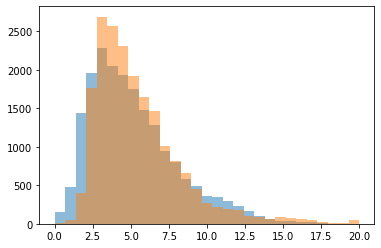

In [15]:
bins = np.linspace(0, 20, 30)
plt.hist(emds, alpha=0.5, bins=bins)
plt.hist(emd_preds, alpha=0.5, bins=bins);

In [16]:
diff = emds.reshape(-1,1) - emd_preds

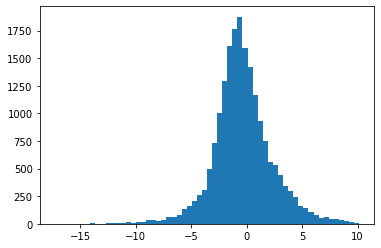

In [17]:
plt.hist(diff, bins=60);

In [18]:
import models

In [31]:
model = models.EdgeNet(input_dim = 3, big_dim = 32)
model.load_state_dict(torch.load('/anomalyvol/experiments/deletemeemd/deleteme.best.pth'))
model.to(dev);

In [33]:
jet = X[0]

In [43]:
for i, n in enumerate(diff):
    if n == np.median(diff):
        print(i)

10526


In [47]:
jetpairs[10526]

[75, 101]

In [51]:
emd_preds[10526]

array([3.4820719], dtype=float32)

In [48]:
Js[75]

array([[ 1.84701252e+00,  1.81252831e-01, -2.13085622e-01],
       [ 1.85905528e+00, -1.54479063e-01,  5.62865734e-02],
       [ 1.09606123e+00,  1.39663899e-01, -4.68489534e-03],
       [ 9.04541790e-01,  1.26070940e-01, -2.76106001e-02],
       [ 4.99909306e+00, -2.12259653e-02, -9.70481933e-02],
       [ 1.75314867e+00,  7.14522836e-02, -5.52915931e-02],
       [ 2.42189646e+00,  7.62928960e-02, -4.30013091e-02],
       [ 4.68515106e+02,  1.28492352e-02,  3.37314903e-02],
       [ 3.78772402e+00, -1.74180034e-02, -5.12810499e-02],
       [ 6.29330921e+00, -2.47106913e-02, -3.89560611e-02],
       [ 9.08385086e+01, -9.43872959e-03, -2.47310103e-02],
       [ 3.62495941e+02, -1.47571924e-02, -7.06267363e-03],
       [ 2.53630325e+02, -1.22111800e-02, -1.45603419e-02],
       [ 1.94552979e+02, -1.06982353e-02, -1.60874129e-02]])

In [49]:
Js[101]

array([[ 1.31375418e+01,  3.70518311e-01,  1.13488440e-01],
       [ 1.02689457e+01,  3.54390963e-01,  1.29251723e-01],
       [ 1.36446629e+01,  3.60180958e-01,  8.27483576e-02],
       [ 1.40994227e+00,  2.13108047e-01,  2.97629957e-01],
       [ 4.85710859e+00,  3.12917455e-01,  1.67766277e-01],
       [ 1.39712489e+00,  3.14256891e-01, -1.55552920e-01],
       [ 5.36326694e+00,  2.49797686e-01,  2.28044574e-01],
       [ 3.04084802e+00,  1.76497563e-01, -3.00134550e-01],
       [ 1.43849564e+00,  1.34392127e-01,  2.96740476e-01],
       [ 1.26569185e+01,  3.01432594e-01,  9.01797455e-02],
       [ 1.52114224e+00,  2.66911849e-01,  4.83284038e-02],
       [ 1.25325167e+00,  2.51659616e-01, -9.00355834e-02],
       [ 5.32703876e+00,  2.54101261e-01, -2.67519909e-02],
       [ 1.69492352e+00,  2.15073927e-01, -1.45113077e-01],
       [ 1.12957704e+00,  2.09151014e-01,  1.43446628e-01],
       [ 1.56561458e+00, -2.97824301e-02,  2.69235913e-01],
       [ 6.69655740e-01,  2.39981874e-01